# Epidemic spreading on networks. C.4.5 Networks course HT2020
## An short tutorial on implementing an SIR epidemic model in networks.
### Author: R. Maria del Rio-Chanona
### Disclaimer: this notebook is just a tutorial meant for teaching purposes. It is not a forecast nor an attempt to model the spreading of COVID-19

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import pandas as pd

## The agents
To model an epidemic process, we assume that the agents of a population can be divided into three classes: 
* i) the susceptible $S$, who can contract the disease, 
* ii) the infected $I$, those individuals who have the disease, and 
* iii) the recovered $R$, who no longer contract or spread the disease.

Susceptible agents can become infected, and infected agents can recover. We denote the transition between states by $\to$. The allowed transitions are

$$ S \to I \to R.$$

We consider a population of $N$ agents, and we run our simulation in discrete time steps. Each agent $i$ has degree $k_i$ (i.e., $k_i$ "friends"), and meets with *all* of them every time step (the agent meets with no one else besides her friends). We use a network to encode this information. In this network, nodes are agents, and edges denote that two people meet at each time step (the network is constant through time). On average each agent has $\bar{k} = \sum_{i=1}^Nk_i$ friends.



## The network of interactions between agents
We consider two null models for the networks of interactions. The Erdos-Renyi model which has a Poisson degree distribution and the Barabasi-Albert model which has a scale-free degree distribution. Run code below to see a plot of each network.

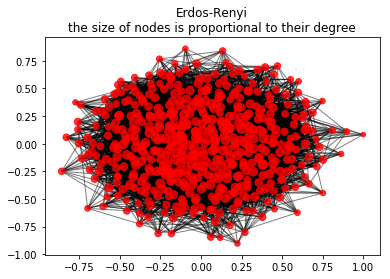

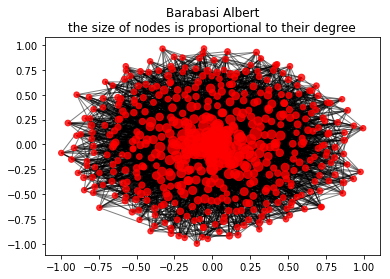

In [2]:
# number of agents
N = 500
# mean degree of the networks
k = 20
np.random.seed(1234)
# erdos renyi network with mean_degree
G = nx.erdos_renyi_graph(N, k/N)
A_erdos = nx.to_numpy_array(G)
# scale free network with 0.5*mean_degree edges
G_barabasi = nx.barabasi_albert_graph(N, int(k/2))
A_barabasi = nx.to_numpy_array(G_barabasi)

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, alpha = 0.8, node_size=[3*i for i in list(dict(G.degree).values())])
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Erdos-Renyi\nthe size of nodes is proportional to their degree")
plt.show()

pos = nx.spring_layout(G_barabasi)
nx.draw_networkx_nodes(G_barabasi, pos, alpha = 0.8, node_size=[3*i for i in list(dict(G_barabasi.degree).values())])
nx.draw_networkx_edges(G_barabasi, pos, alpha=0.5)
plt.title("Barabasi Albert\nthe size of nodes is proportional to their degree")
plt.show()

## Epidemic spreading process

At the beginning of the simulation, there is a $\rho_0$ fraction of infected agents; all other agents are susceptible. We then simulate discrete time steps the following:

* An infected individual will recover is $\gamma$ time steps have passed since infection, i.e., we have an $I \to R$ transition after $\gamma$ days.
* At each time step agents meet in pairwise interactions with their friends. If a susceptible agent meets an infected agent, the susceptible agent becomes infected with probability $\beta$

The simulation ends when there are no infected individuals. We implement this model in the following python function.

In [3]:
def run_SIR(A, γ, β, ρ_0, N, T):
    """ function that runs a simulation of an SIR model on a network.
    Args:
        A(np.array): adjacency matrix of the network
        γ(float): recovery rate
        β(float): infection probability
        ρ_0(float): initial fraction of infected individuals
        N(int): number of agents (nodes)
        T(int): number of time steps simulated
    """
    # setting initial conditions
    s = np.zeros(T)
    inf = np.zeros(T)
    r = np.zeros(T)
    # dictionary with state of node.0 = s, 1= i, 2 = r.
    x = {}
    # time since infection
    x_timeinf = {}
    for i in range(N):
        if i <= N*ρ_0:
            x[i] = 1 #"infected"
            x_timeinf[i] = 1
            inf[0] += 1
        else:
            x[i] = 0 # "susceptible"
            x_timeinf[i] = 0
            s[0] += 1
            
    # running simulation
    for t in range(1,T):
        s[t] = s[t-1]
        inf[t] = inf[t-1]
        r[t] = r[t-1]
        # first check which agents have recovered
        for i in range(N):
            # if infected
            if x[i] == 1:
                if x_timeinf[i] < γ:
                    x_timeinf[i] += 1
                else:
                    x[i] = 2 #"recovered"
                    r[t] += 1
                    inf[t] += -1
        # Now check contagion    
        for i in range(N):
            #if susceptible
            if x[i] == 0:
                for j in range(N):
                    # if agents are friends
                    if A[i,j] == 1:
                        # if friend is infected
                        if x[i] == 0 and x[j] == 1:
                            # with prob β infect
                            if np.random.rand() < β:
                                x[i] = 1
                                inf[t] += 1
                                s[t] += -1
                                break
    return s, inf, r

### Defining our initial conditions and running one simulation

In [4]:
# time of simulation
T = 80
# number of simulations
N_sim = 20
# number of agents
N = 500
# initial fraction of infected
ρ_0 = 0.005
# infection rate
β = 0.03
# recovery rate
γ = 5
# mean degree of the networks
k = 20
# defining an erdos renyi network
G = nx.erdos_renyi_graph(N, k/N)
A_erdos = nx.to_numpy_array(G)

When we run the model once we observe the typical behaviour of an SIR model. Broadly speaking, we see an exponential-like growth for the number of infected people at the beginning, which then saturates and decays. The number of susceptible agents decreases slowly at the beginning, but soon it starts decreasing rapidly until a small amount of the population remains susceptible. The recovered population initially increases slowly,  but then also increases in a faster manner reaching, until most of the population is in the recovered class.

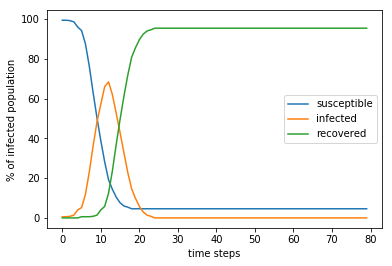

In [5]:
np.random.seed(123)
s_erdos, inf_erdos, r_erdos = run_SIR(A_erdos, γ, β, ρ_0, N, T)
plt.plot((100/N)*s_erdos, label="susceptible")
plt.plot((100/N)*inf_erdos, label="infected")
plt.plot((100/N)*r_erdos, label="recovered")
plt.xlabel("time steps")
plt.ylabel("% of infected population")
plt.legend()
plt.show()

## Flattening the curve!
### Consider two scenarios for each network
### i) (baseline) Agents continue to meet all of their friends each time step 
### ii) (protective) Agents only meet half of their number of friends each time step (always the same half)

In our baseline scenario we had mean degree $\bar{k} = 20$. In the second scenario we consider networks with $\bar{k} = 10$. For simplicity we draw graphs again from the same null model but with with the new mean degree.


## Multiple runs for different scenarios
We run the baseline and the protective scenario for both network. We run $N_{sim}= 50$ different simulations and plot the average  $ \pm \sigma$ (where $\sigma$ is the standard deviation). Dependin on your computer power, consider lowering the number of simulations.

In [6]:
# time of simulation
T = 80
# number of simulations
N_sim = 50
# number of agents
N = 500
# initial fraction of infected
ρ_0 = 0.005
# infection rate
β = 0.035
# recovery rate
γ = 5
# mean degree of the networks
k = 20

np.random.seed(1234)
# erdos renyi network with mean_degree
G = nx.erdos_renyi_graph(N, k/N)
A_erdos = nx.to_numpy_array(G)
# erdos renyi network with 0.5*mean_degree
G_half = nx.erdos_renyi_graph(N, 0.5* k/N)
A_erdos_half = nx.to_numpy_array(G_half)
# scale free network with 0.5*mean_degree edges
G_barabasi = nx.barabasi_albert_graph(N, int(k/2))
A_barabasi = nx.to_numpy_array(G_barabasi)
# scale free network with 0.25*mean_degree edges
G_barabasi_half = nx.barabasi_albert_graph(N, int(k/4))
A_barabasi_half = nx.to_numpy_array(G_barabasi_half)

In [7]:
# define narrays to keep the data
S_array_erdos, I_array_erdos, R_array_erdos = np.zeros([N_sim, T]), np.zeros([N_sim, T]), np.zeros([N_sim, T])
S_array_erdos_half, I_array_erdos_half, R_array_erdos_half = np.zeros([N_sim, T]), np.zeros([N_sim, T]), np.zeros([N_sim, T])
S_array_barabasi, I_array_barabasi, R_array_barabasi = np.zeros([N_sim, T]), np.zeros([N_sim, T]), np.zeros([N_sim, T])
S_array_barabasi_half, I_array_barabasi_half, R_array_barabasi_half = np.zeros([N_sim, T]), np.zeros([N_sim, T]), np.zeros([N_sim, T])
# running simulations

for n in range(N_sim):
    # print("sim", n)
    # running one simulation
    s_erdos, inf_erdos, r_erdos = run_SIR(A_erdos, γ, β, ρ_0, N, T)
    s_erdos_half, inf_erdos_half, r_erdos_half = run_SIR(A_erdos_half, γ, β, ρ_0, N, T)
    s_barabasi, inf_barabasi, r_barabasi = run_SIR(A_barabasi, γ, β, ρ_0, N, T)
    s_barabasi_half, inf_barabasi_half, r_barabasi_half = run_SIR(A_barabasi_half, γ, β, ρ_0, N, T)
    # saving simulation in array
    S_array_erdos[n, :], I_array_erdos[n, :], R_array_erdos[n, :] = s_erdos, inf_erdos, inf_erdos
    S_array_erdos_half[n, :], I_array_erdos_half[n, :],  R_array_erdos_half[n, :] = s_erdos_half, inf_erdos_half, r_erdos_half
    S_array_barabasi[n, :], I_array_barabasi[n, :],  R_array_barabasi[n, :] = s_barabasi, inf_barabasi, r_barabasi
    S_array_barabasi_half[n, :], I_array_barabasi_half[n, :], R_array_barabasi_half[n, :] = s_barabasi_half, inf_barabasi_half,r_barabasi_half


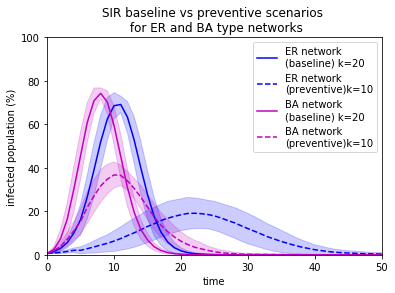

In [8]:
plt.plot(np.mean((100/N)*I_array_erdos, axis=0), "b-", label="ER network\n(baseline) k=20")
plt.fill_between([i for i in range(T)], np.mean((100/N)*I_array_erdos, axis=0) - np.std((100/N)*I_array_erdos, axis=0), np.mean((100/N)*I_array_erdos, axis=0) + np.std((100/N)*I_array_erdos, axis=0), color='b', alpha=0.2) #std curves.

plt.plot(np.mean((100/N)*I_array_erdos_half, axis=0), "b--", label="ER network\n(preventive)k=10")
plt.fill_between([i for i in range(T)], np.mean((100/N)*I_array_erdos_half, axis=0) - np.std((100/N)*I_array_erdos_half, axis=0), np.mean((100/N)*I_array_erdos_half, axis=0) + np.std((100/N)*I_array_erdos_half, axis=0), color='b', alpha=0.2) #std curves.

plt.plot(np.mean((100/N)*I_array_barabasi, axis=0), "m-", label="BA network\n(baseline) k=20")
plt.fill_between([i for i in range(T)], np.mean((100/N)*I_array_barabasi, axis=0) - np.std((100/N)*I_array_barabasi, axis=0), np.mean((100/N)*I_array_barabasi, axis=0) + np.std((100/N)*I_array_barabasi, axis=0), color='m', alpha=0.2) #std curves.

plt.plot(np.mean((100/N)*I_array_barabasi_half, axis=0), "m--", label="BA network\n(preventive)k=10")
plt.fill_between([i for i in range(T)], np.mean((100/N)*I_array_barabasi_half, axis=0) - np.std((100/N)*I_array_barabasi_half, axis=0), np.mean((100/N)*I_array_barabasi_half, axis=0) + np.std((100/N)*I_array_barabasi_half, axis=0), color='m', alpha=0.2) #std curves.

plt.xlabel("time")
plt.ylabel("infected population (%)")
plt.legend()
plt.title("SIR baseline vs preventive scenarios \n for ER and BA type networks")
plt.ylim([0,100])
plt.xlim([0, 50])
plt.show()

## Conclusion

This is a toy-model SIR model epidemic spreading that highlights the importance of taking preventive measures. In this notebook, we model "preventive measures" as meeting fewer people on average. However, different measures can be modelled with different parameters. For example, cleaning surfaces and washing hands would decrease the probability of infection $\beta$.

The overall goal of this notebook is to provide a short tutorial on how epidemic processes can be modelled on networks. Please feel free to explore different scenarios and play with different parameters. Once again, this notebook is not meant for forecasting papers nor does it claim to model the current propagation of COVID-19

Feedback and suggestions are very welcomed. 


# See following references for more information about epidemic processes in networks
​
* Pastor-Satorras, Romualdo, et al. "Epidemic processes in complex networks." Reviews of modern physics 87.3 (2015): 925.
* Kiss, István Z., Joel C. Miller, and Péter L. Simon. "Mathematics of epidemics on networks." Cham: Springer 598 (2017).

In [ ]:
# saving the data of infected
df = pd.DataFrame(S_array_erdos, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/S_erdos.csv")
df = pd.DataFrame(I_array_erdos, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/I_erdos.csv")
df = pd.DataFrame(R_array_erdos, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/R_erdos.csv")
df = pd.DataFrame(S_array_erdos_half, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/S_erdos_half.csv")
df = pd.DataFrame(I_array_erdos_half, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/I_erdos_half.csv")
df = pd.DataFrame(R_array_erdos_half, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/R_erdos_half.csv")
df = pd.DataFrame(S_array_barabasi, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/S_barabasi.csv")
df = pd.DataFrame(I_array_barabasi, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/I_barabasi.csv")
df = pd.DataFrame(R_array_barabasi, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/R_barabasi.csv")
df = pd.DataFrame(S_array_barabasi, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/S_barabasi.csv")
df = pd.DataFrame(I_array_barabasi_half, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/I_barabasi_half.csv")
df = pd.DataFrame(R_array_barabasi_half, columns=["t" + str(t) for t in range(T)])
df.to_csv("data/R_barabasi_half.csv")